This python program generates a number of steps an individual takes per hour for a given time period. The program simulates fit bit step data.

Commissioned by T.B. Dijkhuis.

Written by H. Kruize, 2022.

# About the model

This data generation model uses the normal distribution function to generate steps per hour for an individual. By adjusting the parameters given to the distribution function, multiple movement patterns (movement personalities) are generated that each will return a different number of steps made for the given hour. After retrieving the steps made for the given hour, the program adds a random number (jitter in the code) to represent the day to day fluctuations in an individuals movement. Lastly, the program adjusts for drift, meaning over time the individual will walk less and less, depending on the parameters given to the program. After 24 hours a new day starts and the provided (main) movement pattern might be used depending on the user input for the individual to have data generated for. The program generates two data sets for each individual. 

The first data set is used to make a simple solution of the Simulation Virtual Fitness Coach prediction without using data quality checks, visualisations, database, different algorithms, cross validation or visualisations. Soley the prepration of the fitbit data, model generation and saving the model. The prediction model code is written by Talko B. Dijkhuis, 2022.

The prediction model is applied to the second data set to generate hourly based predictions. These predictions are used to simulate motivational messages and their effect on the number of steps taken the next hour. Depending on the selected motivational effect (specified parameters for the given individual) the effect will vary per day or per the given hours. The modified steps per hour and related variables are updated and the new data is saved in a new output file in order to preserve the original data set.

### Model assumptions and important information

- The program uses an input file which contain the selected options for all the parameters for each individual for which data should be generated. See inputFileExplained.txt for an example on how this file should be structured and an explanation of the input parameters.

- The program generates steps per hour for all hours in the day.

- The first day for which data is generated is always a Monday.

- Because the interest is in working days and office hours, the variable steps_at_18 is the sum of the steps taken between 7.00 and 18.59. 

- There are a fixed number of movement patterns/personalities which represent how active an individual is at each hour of the day. The given personality (input parameter) is the dominant movement pattern. However there will be days which will use a non dominant pattern randomly picked or the imaginary fitbit did not generate data for a day. This represents the fact that people have days where their routine is off or forget to wear their smart watch/step counter. The movement patterns available will be explained below. If needed, the movement patterns can be expanded in the future.

- As stated above, the program adds drift to the data. **The drift is always negative**. So over time the number of steps taken per hour goes down. In the future this could be adjusted.

- The effect of a motivational message is on the steps taken in the hour after the hour the message is sent.

- There are a fixed number of motivational effects a motivational message can have. See below for an overview of options. If needed, the effects can be expanded in the future.

#### Movement patters, also referred to as movement personalities

To represent diversity in activity the program has seven movement patterns an individual can follow:

- morning_two, the most steps per hour are walked in the morning. After this peak in steps there is another peak in steps taken later in the day, however this one is lower compared to the one in the morning.

- morning_three, the most steps per hour are walked in the morning. After this peak in steps there are two other peaks in steps taken later in the day, however these are lower compared to the one in the morning.

- afternoon_three, the most steps are taken around noon. However there is also a smaller peak in the morning and one around dinner time.

- evening_two, the most steps per hour are walked in around/during dinner time. Before this peak in steps there is another peak in steps taken earlier in the day, however this one is lower compared to the one in the evening.

- evening_three, the most steps per hour are walked in around/during dinner time. Before this peak in steps there are two other peaks in steps taken earlier in the day, however these are lower compared to the one in the evening.

- day_one, there is one wide peak resulting in a low diversity is steps per hour.

- day_three, there are three leveled peaks creating a bit more diversity in steps per hour compared to day_one.

To create a bit more diversity, the program has a second parameter related to movement patterns: movement intensity. This parameter specifies the intensity of activity. Two individuals can have the same movement pattern, but if the intensity differs one if them will walk more and have an higher steps per hour compared to the other individual. The options for this parameter are:

- high, the individual is very active.

- average, the individual moves the "normal" amount.

- low, the individual moves only when needed.

These parameters are not based on scientific data.

#### Effect motivational messages

As stated above, the prediction model generated for each individual with the first data set, is applied to add motivational effects to the second data set of each individual.

First the program applies the predict function of the model created on the full second data set. The model predicts if the threshold will be met at the end of the day for each hour based on the steps taken up to that hour (0 if not expected to be met; 1 if expected to be met).

The prediction will be used to modify the behaviour of the individual on the days the prediction is accurate, a true negative.

The moments of the day at which a message will be sent is one of the parameters linked to motivation, which is a list with all the hours as integers. The effect of the message is seen in the hour after a message is sent.

The effect of the (virtual) coaching/motivation message can be negative, positive or neutral. Which one is the main is dependend on the coachability of the individual, also reffered to as motivation personality. The personalities are devided in to two groups, which have their own sub-options:

- **day effect**: the motivation effect differs between days. There is a main motivation personality effect that is dominant for x% of the days. The rest of the days the motivational effect is randomly drawn from the other two options. Another option is that there is no clear pattern in the motivation effect, so there is no dominant effect and each day the effect is randomly drawn from the three options named above. This results in four sub-options for the day effect:

    1) positive, most days the motivation results in <u>more</u> steps being made the hour after the message is sent.
    
    2) negative, most days the motivation results in <u>less</u> steps being made the hour after the message is sent.
    
    3) neutral, most days the motivation results in <u>no change in</u> steps being made the hour after the message is sent.
    
    4) random, there is no main motivation personality effect. The effect is randomly decided for each day from negative, positive or neutral.


- **moment effect**: the motivation effect differs between moments in the day. For example, in the morning the effect of the message is *always* positive and the rest of the day it is random. The next list shows the motivation personalities for when the list of hours is [10,13,16]:

    1) 10h_positive, the rest will be random
    
    2) 10h_negative, the rest will be random
    
    3) 10h_neutral, the rest will be random
    
    4) 13h_positive, the rest will be random
    
    5) 13h_negative, the rest will be random
   
    6) 13h_neutral, the rest will be random
    
    7) 16h_positive, the rest will be random
    
    8) 16h_negative, the rest will be random
    
    9) 16h_neutral, the rest will be random
    
**Note**: There are more possibilities for the moment effect, for now, this seems more than enough to start with. There is no divergence from the main effect in the main moment for the moment based personalities. It is **always** the main effect. Also, in the moment based personalities the random also includes the main effect linked to the main moment to keep things simple. So the random contains positive, negative and neutral as option despite whatever option was given as dominant for the selected hour.

## The code

First all the needed libraries are loaded.

In [90]:
# Import libraries for the data generation part
import pandas as pd
import numpy as np
import math
import random

## Functions needed for data generation

getStepsNormal(): The function that returns the number of steps for the given hour using the normal probabilty distribution function.

In [91]:
# Get steps by following the normal distribution function
# time = current hour, mean = the peak of the distribution, std = standard deviation, 
def getStepsNormal(time, mean, std, stepAdjustment):
    """
    This function uses the normal distribution function to retrieve the probabilty at the current time, so the x-axis is in 
    time, and returns the steps for that moment in time. After retrieving the probabilty from the function it is multiplies 
    by maxSteps to get a high enough number of steps for the current time.
    Parameters:
        time, is an integer which is the current hour to calculate the number of set steps for.
        mean, an integer representing the median needed for the normal distribution function.
        std, an integer representing the standard deviation for the normal distribution function.
        stepAdjustment, an integer that modifies the final size of the returned step.
    """
    # Get the variables needed to feed the exponential
    before_e = 1 / (std * math.sqrt(2.0*math.pi))
    e_power = -1/2 * (((time-mean) / std) * ((time-mean) / std))
    
    probability = before_e * math.exp(e_power)
    
    # Probability is between 0 and 1, adjust with a maxSteps
    # This will always result is a perfect curve
    # Steps are integers, so we correct for the floating points with the int()
    return int(probability*stepAdjustment)

addRandomness(): this function adds a random number to the steps generated by normal distribution function. This randomness represents the day to day fluctuations of an individual's steps per hour.

In [92]:
def addRandomness(step, moveIntensity, time):
    """
    This function adds a slightly random number to increase variabilty in steps per hour. The randomness is movement 
    intensity dependend as well as time dependend.
    Parameters:
        step, an integere representing the steps per hour.
        moveIntensity, a string representing how active the person is. This variable has effect on the randomness.
        time, an integer representing the current hour for which the step are being modified.
    """
    # To make the step adjustment more random the program will randomly select from an array of numbers as well as use
    # an adjustment linked to how active a person is
    jitterManipulation1 = [0.05, 0.1, 0.5, 1.0, 2.5, 5.0] 
    jitter = 0
    
    # First round of jitter generation
    if moveIntensity == "low":
        jitter = int(np.random.randint(-20,20)*random.choice(jitterManipulation1))
    elif moveIntensity == "average":
        jitter = int(np.random.randint(-10,35)*random.choice(jitterManipulation1))
    elif moveIntensity == "high":
        jitter = int(np.random.randint(-5,50)*random.choice(jitterManipulation1))
    else:
        sys.exit("Unrecognized movement intensity.\nExiting program.")
    # Second round of jitter generation
    jitter = int(jitter*random.choice(jitterManipulation1))
    
    # Adding the jitter to step
    step = step + jitter
    
    # Steps cannot be less than 0!
    if step < 0:
        step = 0
        
    # Adding a random multiplication based on time of day, idea from Talko  
    if 0 <= time < 7:
        n = random.random()
        if n < 0.7:
            step = 0
        else:
            step = int(step * 0.25)
    elif 7 < time <= 18:
        n = random.random()
        step = int((step * 3) * n)
    elif 18 < time:
        n = random.random()
        step = int((step * 1) * n)
    
    return step

addDrift(): this function modifies the steps to apply negative drift to the dataset following individual specific parameters for the boundaries when drift happens and the percentage of steps that is lost for each boundary.

In [93]:
def addDrift(step, day, maxDays, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, driftPercentageTwo, driftPercentageThree, driftPercentageFour):
    '''
    Drift following percental decrease with four boundaries.
    Parameters:
        step, an integer which is the number of steps at the moment for which drift needs to be added.
        day, the current day. Depending on the boundaries and the current day the step may be changed little or a lot.
        maxDays, the simulation time in days. 
        boundOne/Two/Three/Four, the boundaries when drift starts to happen (boundOne) or increases (boundTwo, boundThree, 
            boundFour).
        driftPercentageOne/Two/Three/Four, the percentage of the steps reduced from steps due to drift.
    '''
    # Get max number of days in 1% for easy calculation
    maxDaysPercentage = maxDays / 100
    
    # Get the boundaries for drift
    boundaryOne = int(boundOne * maxDaysPercentage)     # The first boundIncrement% of the days nothing happens
    boundaryTwo = int(boundTwo * maxDaysPercentage)     # Drift starts appearing around this time
    boundaryThree = int(boundThree * maxDaysPercentage) # Drift is increasing around this time
    boundaryFour = int(boundFour * maxDaysPercentage)   # Drift increases even more around this time
    
    # Based on where in time we are (based on days) apply drift
    if boundaryOne <= day < boundaryTwo: # The first time to add drift, drift starts
        step = step - int((step / 100) * driftPercentageOne)
    elif boundaryTwo <= day < boundaryThree: # The drift increases
        step = step - int((step / 100) * driftPercentageTwo)
    elif boundaryThree <= day < boundaryFour: # The drift increases some more
        step = step - int((step / 100) * driftPercentageThree)
    elif boundaryFour <= day: # Maximum drift at the end of the simulation time
        step = step - int((step / 100) * driftPercentageFour)
    
    return step

getMovePatternArray(): this function creates an array which dictates on which day the dominant movement pattern is applied and which days one of the other two are applied.

In [94]:
def getMovePatternArray(mp, maxDays):
    """
    This function generates and returns an array with the length of the max number of simulations days (derived from 
    tmax). The biggest portion of this array will be filled with the main personality given as an argument. The rest 
    of the days will be filled with the other six personalities, randomly drawn.
    Parameters:
        mp, the main movement pattern (personality).
        maxDays, the maximum time to generate data for in days.
    """
    # Based on how many days will be simulated, calculate how many of these should the main personality
    # Get a random percentage to work with and get the number of days associated with that percentage
    percent = np.random.randint(65,80)
    daysMain = int((maxDays / 100) * percent)
    
    # Start filling the array
    mpArray = []
    for day in range(maxDays):
        # Fill the first part of the array, so the first days, with the main movement pattern
        if day < daysMain:
            mpArray.append(mp)
        else:
            # Now start adding the other possible movement patterns, randomly selected
            mpTwo = random.choice(["morning_two","morning_three","afternoon_three","evening_two","evening_three","day_one","day_three"])
            # Only use the other six, not the main
            while mpTwo == mp:
                mpTwo = random.choice(["morning_two","morning_three","afternoon_three","evening_two","evening_three","day_one","day_three"])
            mpArray.append(mpTwo)

    # Now shuffle the array so that the first days do not have to be the main movement pattern/personality
    random.shuffle(mpArray)
    
    return mpArray

getPatternBasedStep(): this function retrieves the number of steps for the selected hour and for the movement pattern of the current day.

In [95]:
def getPatternBasedStep(mp, time, stepAdjustment, peakOne, peakTwo, peakThree, widthOne, widthTwo):
    """
    This retrieves and returns the correct number for steps per hour based on the movement pattern given and the current 
    time.
    Parameters:
        mp, the movement pattern applied at the moment of calling this function.
        time, the currentHour for which the number of step per hour needs to be retrieved.
        stepAdjustment, an arbitrary integer that modifies the final size of the returned step.
        peakOne, location of the first peak in the movement pattern.
        peakTwo, location of the second peak in the movement pattern.
        peakThree, location of the third peak in the movement pattern if there is a third peak.
        widthOne, the width of the main peak of the movement pattern.
        widtTwo, the width of the other peak(s) of the movement pattern.
    """
    step = 0
        
    # Based on the movement pattern of activity we need different shapes of the normal distribution, 
    # so check for movement pattern value and currentHour to apply the right values to the normal distribution
    # First check which movement pattern to use, than check the currentHour
    if mp == "morning_three":
        #mean highest peak = 9
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([8,9,10])
            peakTwo = random.choice([13,14,15])
            peakThree = random.choice([18,19,20])
            widthOne = random.choice([2,3])
            widthTwo = random.choice([4,5,6])
        # Check the time following the tripleNormal idea to get the steps for currentHour
        if time < 12:
            #step = getStepsNormal(time, 9, 3, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthOne, stepAdjustment)
        elif time < 18:
            #step = getStepsNormal(time, 14, 4, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthTwo, stepAdjustment)
        else:
            #step = getStepsNormal(time, 19, 5, stepAdjustment)
            step = getStepsNormal(time, peakThree, widthTwo, stepAdjustment)
    elif mp == "morning_two":
        #mean highest around 9h, second peak is wider and lower
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([8,9,10])
            peakTwo = random.choice([17,18,19])
            widthOne = random.choice([2,3])
            widthTwo = random.choice([4,5,6])
        # Get the steps for currentHour
        if time < 13:
            #step = getStepsNormal(time, 9, 3, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthOne, stepAdjustment)
        else:
            #step = getStepsNormal(time, 18, 5, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthTwo, stepAdjustment)
    elif mp == "afternoon_three":
        #mean highest peak = 15
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([8,9,10])
            peakTwo = random.choice([12,13,14])
            peakThree = random.choice([18,19,20])
            widthOne = random.choice([2,3])
            widthTwo = random.choice([4,5,6])
        # Get the steps for currentHour
        if time < 12:
            #step = getStepsNormal(time, 9, 4, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthTwo, stepAdjustment)
        elif time < 18:
            #step = getStepsNormal(time, 13, 3, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthOne, stepAdjustment)
        else:
            #step = getStepsNormal(time, 20, 6, stepAdjustment)
            step = getStepsNormal(time, peakThree, widthTwo, stepAdjustment)
    elif mp == "evening_three":
        #mean highest peak = 20
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([8,9,10])
            peakTwo = random.choice([12,13,14])
            peakThree = random.choice([19,20,21])
            widthOne = random.choice([2,3])
            widthTwo = random.choice([4,5,6])
        # Get the steps for currentHour
        if time < 12:
            #step = getStepsNormal(time, 9, 4, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthTwo, stepAdjustment)
        elif time < 17:
            #step = getStepsNormal(time, 15, 4, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthTwo, stepAdjustment)
        else:
            #step = getStepsNormal(time, 20, 2, stepAdjustment)
            step = getStepsNormal(time, peakThree, widthOne, stepAdjustment)
    elif mp == "evening_two":
        #mean highest around 19h, second peak is wider and lower
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([9,10,11])
            peakTwo = random.choice([18,19,20])
            widthOne = random.choice([2,3])
            widthTwo = random.choice([4,5,6])
        # Get the steps for currentHour
        if time < 15:
            #step = getStepsNormal(time, 10, 5, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthTwo, stepAdjustment)
        else:
            #step = getStepsNormal(time, 19, 3, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthOne, stepAdjustment)
    elif mp == "day_three":
        #3 peaks with the same height
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([8,9,10])
            peakTwo = random.choice([12,13,14])
            peakThree = random.choice([18,19,20])
            widthOne = random.choice([3,4,5])
        # Get the steps for currentHour
        if time < 11:
            #step = getStepsNormal(time, 8, 4, stepAdjustment)
            step = getStepsNormal(time, peakOne, widthOne, stepAdjustment)
        elif time < 17:
            #step = getStepsNormal(time, 13, 4, stepAdjustment)
            step = getStepsNormal(time, peakTwo, widthOne, stepAdjustment)
        else:
            #step = getStepsNormal(time, 19, 4, stepAdjustment)
            step = getStepsNormal(time, peakThree, widthOne, stepAdjustment)
    elif mp == "day_one":
        # Get the locations of the peaks of the current day
        # After resetting the day, the currentHour is set to zero. So only then we need to adjust the peaks and width
        if time == 0: 
            peakOne = random.choice([12,13,14])
            widthOne = random.choice([9,10,11])
        # Get the steps for currentHour
        # only one peak around 13 which is very wide and not moment of day dependent
        #step = getStepsNormal(time, 13, 10, stepAdjustment)
        step = getStepsNormal(time, peakOne, widthOne, stepAdjustment)
    else:
        print("Current movement pattern is: " + mp + ".")
        sys.exit("Incorrect movement pattern detected.\nExiting program.")
    
    # Now return the steps per hour for the given time and the peaks and width (in case they were updated)
    return ([step, peakOne, peakTwo, peakThree, widthOne, widthTwo])

dataGeneration(): this function calls all the previous functions to generate the data for the individual given as a parameter to this function.

In [96]:
def dataGeneration(individual = "testing", maxSimulationTime = 90, getThreshold = True, MovePattern = "afternoon_three", MovementIntensity = "high", boundOne = 10, boundTwo = 20, boundThree = 50, boundFour = 70, driftPercentageOne = 10, driftPercentageTwo = 30, driftPercentageThree = 40, driftPercentageFour = 50, motivationTime = '[9-12-15-17]', motivationType = 'day_positive', motivationStepAdjustment = 'big', datasetVersion = 0):
    """
    This function generates the number of steps an individual walked per hour. The steps are 
    retrieved following a probability distribution. At the end of the function, the data 
    retrieved is exported to an csv-file following the name of the individual.
    Parameters:
        individual, a string representing the name of the test subject/ treatment id.
        maxSimulationTime, is an integer which indicates for how many days data should be generated.
        MovePattern, a string represting in which part of the day the individual is most active. The options are: 
            morning_two, morning_three, afternoon_three, evening_two, evening_three, day_one or 
            day_three. The time of day represents in which time frame the highest peak will be. If it says day, 
            there will either be one wide peak or three evenly high peaks. The number after the underscore 
            indicates how many peaks there will be. It is difficult to have two peaks with afternoon, therefore 
            that movement pattern only has one option. Also this is the main distribution to use, on the other days one 
            of the other six will randomly selected. 
        MovementIntensity, a string representing how active the person is. This variable allows 
            for modification of the hight of the steps per hour and therefore per day.
        boundOne, boundTwo, boundThree and boundFour are the boundaries (in percentage) when drift starts/increases.
        driftPercentageOne, driftPercentageTwo, driftPercentageThree and driftPercentageFour is the percentage with 
            which steps decreases after each boundary is passed.
        motivationTime, the hours at which a motivational message is sent.
        motivationType, a string that tells the program what the effect of the motivational message was.
        motivationStepAdjustment, represents how big the change in the step is. Options are big, average, small or a 
            number can be provided.
        datasetVersion, an integer which decides where the data is saved.
    """
    # Set variables relevant for the simulation loop
    tMax = maxSimulationTime*24           # The program simulates per hour so tMAx is in hours
    tCounter = 0
    currentHour = 0
    currentDay = 1
    weekDay = "Monday"
    weekDays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    # We start the weekDays list with Sunday so that we can apply the module operator for updating the weekDay
    currentWeek = 1
    RT = 0                      # Running total per day
    data = []
    
    # Variables for the distributions, they will be adjusted based on the movement pattern of the first day
    peakOne = 9
    peakTwo = 13
    peakThree = 18
    widthOne = 2
    widthTwo = 4
    
    # Variable to adjust the probability to an actual number
    stepAdjustment = 1
    
    # Retrieve on which days which movement pattern should be used
    MP = getMovePatternArray(MovePattern, maxSimulationTime) #MP is the move patterns array in days
    
    # Add some days where there was no movement at all, 
    # which is a percentage of the total number of days for which data will be generated
    nDaysZeroSteps = int((maxSimulationTime / 100) * np.random.randint(5,15))
    DaysZeroSteps = random.sample(range(0, (maxSimulationTime - 1)), nDaysZeroSteps)
    for day in range(nDaysZeroSteps):
        MP[DaysZeroSteps[day]] = "zero_steps"
    
    print("Starting the data generation loop.")
    
    # Simulation loop to generate the steps per hour
    while tCounter < tMax:
        # First get the right movement pattern for the current day and the drift to apply
        currentMP = MP[(currentDay - 1)] # -1 because we start counting days with 1, but list index start with 0
        
        # If only one distribution is used (day as movement pattern, one peak), the number of steps needs to be increased more by stepAdjustment
        if currentMP == "day_one":
            stepAdjustment = 2250
        else:
            stepAdjustment = 750
        
        step = 0
        # Update steps if it is not a day on which there should be zero steps
        if currentMP != "zero_steps":
            # get the step of currentHour for current movement pattern and the (new) values for peak and width
            step, peakOne, peakTwo, peakThree, widthOne, widthTwo = getPatternBasedStep(currentMP, currentHour, stepAdjustment, peakOne, peakTwo, peakThree, widthOne, widthTwo)
        
            # The distributions give standard the same number, add jitter/randomness to break the perfection of the data set
            step = addRandomness(step, MovementIntensity, currentHour)
            
            # Apply drift to the work hours 7h-18h, total of 12 hours
            if 6 < currentHour < 19:
                step = addDrift(step, currentDay, maxSimulationTime, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, driftPercentageTwo, driftPercentageThree, driftPercentageFour)
         
        # Update running total
        if currentHour > 6:
            RT = RT + step
        
        # Add the new data to the list
        data.append([individual, currentWeek, weekDay, currentDay, currentHour, step, RT, currentMP])
        
        # Update counter and time/date
        tCounter = tCounter + 1
        currentHour = currentHour + 1
        # Check if the day needs to be updated
        # If a new day started we also have to reset RT to 0
        if currentHour == 24:
            currentDay = currentDay + 1
            weekDay = weekDays[currentDay%7]
            currentHour = 0
            RT = 0
            # Check if the week needs to be updated, Do we need weeks?
            # We follow a normal week. If the weekend data is not needed it can be ommitted in the analysis
            if currentDay % 7 == 1: 
                currentWeek = currentWeek + 1
                #currentDay = 1 # We need the day to keep going for the movement pattern array
    
    # After the simulation loop we can change the list to a df
    # Working in a pandas df in the simulation loop is not good programming, it is significant slower
    df = pd.DataFrame(data, columns = ['treatment ID', 'week', 'weekday', 'day', 'hour', 'steps', 'running total', 'Todays movement pattern']) 
    
    print("Calculating the data dependend variables.")
    
    # Time to add step dependend variables
    df_18=df.query('hour == 18')
    average_at_18 =df_18['running total'].mean()
    df['average_at_18'] =int(average_at_18) # Average number of steps at the end of the workday
    
    df_merge_18 = df_18[['week', 'day','running total']]
    df_merge_18_2 = df_merge_18.rename(columns = {'running total':'steps_at_18_this_day'})
    df = df.merge(df_merge_18_2, on = ['week', 'day'], how = 'right') # Total of steps during working hours that day
    
    # Add if the threshold was met to the dataframe (1 is met, 0 is not met)
    df['met_threshold'] = ((df['steps_at_18_this_day'] >= df['average_at_18']))
    df['met_threshold'] = df['met_threshold'].astype(int)
    
    # Add most of the parameters from the input file, each in their own column
    # movementPattern, movementIntensity, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, 
    # driftPercentageTwo, driftPercentageThree, driftPercentageFour, motivationTime, motivationType, 
    # motivationStepAdjustment
    df['movementPattern'] = MovePattern
    # Move 'Todays movement pattern' to after movementPattern
    df = df[['treatment ID', 'week', 'weekday', 'day', 'hour', 'steps', 'running total', 'average_at_18', 'steps_at_18_this_day', 'met_threshold', 'movementPattern', 'Todays movement pattern']]
    df['movementIntensity'] = MovementIntensity
    df['boundOne'] = boundOne
    df['boundTwo'] = boundTwo
    df['boundThree'] = boundThree
    df['boundFour'] = boundFour
    df['driftPercentageOne'] = driftPercentageOne
    df['driftPercentageTwo'] = driftPercentageTwo
    df['driftPercentageThree'] = driftPercentageThree
    df['driftPercentageFour'] = driftPercentageFour
    df['motivationTime'] = motivationTime
    df['motivationType'] = motivationType
    df['motivationStepAdjustment'] = motivationStepAdjustment
    
    if getThreshold == True:
        # Get threshold met per day, on one row per day for easy reading
        # Generate a subset of the dataframe 
        df_met = df[df.columns[[1,2,3,4,9]]] # Get week, weekday, day, hour and threshold_met
        # Select for one hour to get one line
        df_met = df_met.query('hour == 23')
        df_met = df_met[df_met.columns[[0,1,2,4]]] #Drop hour
        #print(df_met.iloc[:1])
        # Export to csv    
        exportMet = "Thresholds/" + individual + "_threshold.csv"
        df_met.to_csv(exportMet, index = False)
        print("Exported threshold met per day, on one row per day for easy reading to " + exportMet + ".")
    
    # Export the data to a file named after the individual/treatment ID
    if datasetVersion == 1:
        exportName = "DataVFC/" + individual + ".csv"
    elif datasetVersion == 2:
        exportName = "DataVFC2/" + individual + ".csv"
    else:
        exportName = individual + ".csv"
    print("Exporting data to " + exportName + ".")
    df.to_csv(exportName, index = False)

All the functions are defined, it is time to read in the input file with all the parameters and start generating data by calling the dataGeneration function.

In [97]:
# With a while loop the program reads the input file line by line
# Define the name of the input file
inFile = "test.txt"

with open(inFile) as input_data:
    for line in input_data:
        # Skip lines starting with a # (comment lines)
        if line.strip()[0] == '#':
            continue
        # Read in the information for the next individual from the line,
        # remove any spaces
        # and transform the data to a usable format
        lineStrippedSplit = line.replace(" ","").strip().split(",")
        # Make the variables that are integers, integers
        # Using the trick that python allows lists with variables of different types
        lineStrippedSplit[1] = int(lineStrippedSplit[1])
        lineStrippedSplit[2] = int(lineStrippedSplit[2])
        lineStrippedSplit[5] = int(lineStrippedSplit[5])
        lineStrippedSplit[6] = int(lineStrippedSplit[6])
        lineStrippedSplit[7] = int(lineStrippedSplit[7])
        lineStrippedSplit[8] = int(lineStrippedSplit[8])
        lineStrippedSplit[9] = int(lineStrippedSplit[9])
        lineStrippedSplit[10] = int(lineStrippedSplit[10])
        lineStrippedSplit[11] = int(lineStrippedSplit[11])
        lineStrippedSplit[12] = int(lineStrippedSplit[12])
        #The motivation dependend parameters will be adjusted later
                
        # For easy reading of the code, put all the variables in their own variable
        treatmentID, maxSimulationTime, getThreshold, movementPattern, movementIntensity, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, driftPercentageTwo, driftPercentageThree, driftPercentageFour, motivationTime, motivationType, motivationStepAdjustment = lineStrippedSplit
        
        # Time to check if some variables are within bounds
        assert maxSimulationTime > 0, "Max simulation time should be more than 0"
        assert getThreshold == 0 or getThreshold == 1, "getThreshold should be 0 or 1"
        assert 0 < boundOne < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < boundTwo < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < boundThree < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < boundFour < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < driftPercentageOne < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < driftPercentageTwo < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < driftPercentageThree < 100, "Bounds and percentages should be above 0 and below 100"
        assert 0 < driftPercentageFour < 100, "Bounds and percentages should be above 0 and below 100"
        
        # Generate the data
        print("Starting data generation for " + treatmentID + ".")
        dataV = 1
        dataGeneration(treatmentID, maxSimulationTime, getThreshold, movementPattern, movementIntensity, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, driftPercentageTwo, driftPercentageThree, driftPercentageFour, motivationTime, motivationType, motivationStepAdjustment, dataV)
        print("First round of data generation for " + treatmentID + " is done. Starting the next round of data generation.")
        dataV = 2
        dataGeneration(treatmentID, maxSimulationTime, getThreshold, movementPattern, movementIntensity, boundOne, boundTwo, boundThree, boundFour, driftPercentageOne, driftPercentageTwo, driftPercentageThree, driftPercentageFour, motivationTime, motivationType, motivationStepAdjustment, dataV)
        print("Done generating data for " + treatmentID + ".\n")
        
input_data.closed  


##### NOTE !!!
## Do you get the error: "TypeError: random_sample() takes at most 1 positional argument (2 given)"?
## Rerun the import libraries code above. Later on the program loads some libraries which mess up random_sample().

Starting data generation for test1.
Starting the data generation loop.
Calculating the data dependend variables.
Exporting data to DataVFC/test1.csv.
First round of data generation for test1 is done. Starting the next round of data generation.
Starting the data generation loop.
Calculating the data dependend variables.
Exporting data to DataVFC2/test1.csv.
Done generating data for test1.

Starting data generation for test2.
Starting the data generation loop.
Calculating the data dependend variables.
Exporting data to DataVFC/test2.csv.
First round of data generation for test2 is done. Starting the next round of data generation.
Starting the data generation loop.
Calculating the data dependend variables.
Exporting data to DataVFC2/test2.csv.
Done generating data for test2.



True

# Prediction model generation

Written by T. Dijkhuis as mentioned before and using the first data set generated for each individual/treatment ID

In [98]:
###
# import packages
import os
import glob  
import pickle
import pandas as pd
import numpy as np
#import matplotlib.pyplot as pl
#from matplotlib import dates
import seaborn as sns
from datetime import datetime
from datetime import date
%pylab inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, GridSearchCV

Populating the interactive namespace from numpy and matplotlib


C:\Users\KRHE\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [99]:
#collect number of files
path = r'DataVFC'
for file in os.listdir(path):
    print(file)
    
#read data
# use your own path
path = r'DataVFC'
# advisable to use os.path.join as this makes concatenation OS independent
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
#concatenated_df = pd.read_csv('1119_prep.csv')
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# put candidate files in a dataframe
df = concatenated_df
df.dtypes

test1.csv
test2.csv


treatment ID                object
week                         int64
weekday                     object
day                          int64
hour                         int64
steps                        int64
running total                int64
average_at_18                int64
steps_at_18_this_day         int64
met_threshold                int64
movementPattern             object
Todays movement pattern     object
movementIntensity           object
boundOne                     int64
boundTwo                     int64
boundThree                   int64
boundFour                    int64
driftPercentageOne           int64
driftPercentageTwo           int64
driftPercentageThree         int64
driftPercentageFour          int64
motivationTime              object
motivationType              object
motivationStepAdjustment    object
dtype: object

In [100]:
#function to split data in treatment_id
def split_data(treatment_id):
    # create dataset
    steps = df[df['treatment ID']==treatment_id]
    return steps

In [101]:
#destill treatments
treatments = list(set(df['treatment ID']))
for i in range(len(treatments)):
    print(treatments[i])

test2
test1


In [102]:
df

,treatment ID,week,weekday,day,hour,steps,running total,average_at_18,steps_at_18_this_day,met_threshold,...,boundTwo,boundThree,boundFour,driftPercentageOne,driftPercentageTwo,driftPercentageThree,driftPercentageFour,motivationTime,motivationType,motivationStepAdjustment
0,test1,1,Monday,1,0,2,0,1113,1947,1,...,35,50,65,10,20,40,80,[12],day_positive,big
1,test1,1,Monday,1,1,0,0,1113,1947,1,...,35,50,65,10,20,40,80,[12],day_positive,big
2,test1,1,Monday,1,2,0,0,1113,1947,1,...,35,50,65,10,20,40,80,[12],day_positive,big
3,test1,1,Monday,1,3,0,0,1113,1947,1,...,35,50,65,10,20,40,80,[12],day_positive,big
4,test1,1,Monday,1,4,0,0,1113,1947,1,...,35,50,65,10,20,40,80,[12],day_positive,big
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,test2,13,Saturday,90,19,44,419,870,375,0,...,35,50,65,10,20,40,80,[10-14],moment_14_positive,90
4316,test2,13,Saturday,90,20,66,485,870,375,0,...,35,50,65,10,20,40,80,[10-14],moment_14_positive,90
4317,test2,13,Saturday,90,21,49,534,870,375,0,...,35,50,65,10,20,40,80,[10-14],moment_14_positive,90
4318,test2,13,Saturday,90,22,54,588,870,375,0,...,35,50,65,10,20,40,80,[10-14],moment_14_positive,90


In [103]:
#Function to create train test sets
def train_test(prepared_df):
    #print(prepared_df)
    #split the data in labels 
    steps_prepared_df=prepared_df[prepared_df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])&(prepared_df['hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18])) ]
    X = steps_prepared_df.drop(['treatment ID','week','weekday', 'steps_at_18_this_day','average_at_18','met_threshold','movementPattern', 'Todays movement pattern','movementIntensity','boundOne','boundTwo','boundThree','boundFour','driftPercentageOne','driftPercentageTwo','driftPercentageThree','driftPercentageFour','motivationTime','motivationType','motivationStepAdjustment'], axis = 1)
    y = steps_prepared_df['met_threshold']
    # data splitsen in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
    
    return X_train, X_test, y_train, y_test

2160

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Random Forest Classifier model voor treatment_id test2

model met default waarden.
__________________________________________________________________________________________
468
468
312
312

performance:
435 ms ± 156 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Accuracy van Random Forest Classifier model:  0.9711538461538461

confusion_matrix
               actual bad  actual good
predicted bad         149            3
predicted good          6          154



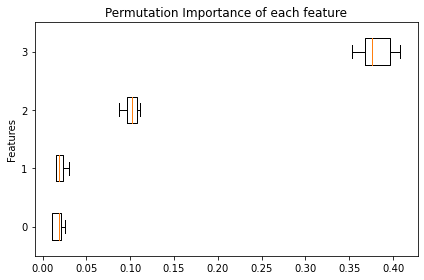

2160

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Random Forest Classifier model voor treatment_id test1

model met default waarden.
__________________________________________________________________________________________
468
468
312
312

performance:
341 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Accuracy van Random Forest Classifier model:  0.9487179487179487

confusion_matrix
               actual bad  actual good
predicted bad         184            9
predicted good          7          112



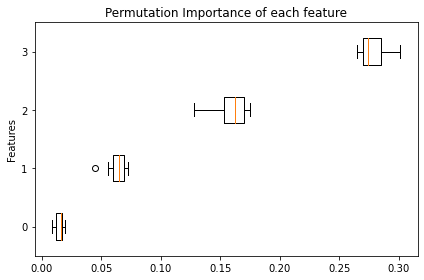

In [104]:
#create dataset en models
pd.options.mode.chained_assignment = None  # default='warn'

for i in range(len(treatments)):
    treatment_id = treatments[i]
    steps = split_data(treatments[i]) 
    prepared_df = steps
    print(prepared_df.shape[0])
    print()
    print('X' * 120)
    print('Random Forest Classifier model voor treatment_id ' + str(treatment_id))
    print()
    print('model met default waarden.')
    print('_' * 90)

    # splitsen van test en train data
    X_train, X_test, y_train, y_test = train_test(prepared_df)
    print(X_train.shape[0])
    print(y_train.shape[0])
    print(X_test.shape[0])
    print(y_test.shape[0])
    
    #model definiëren / Random Forest Classifier
    rfc = RandomForestClassifier(n_estimators=200)

    print()
    print('performance:')
    #model trainen / Random Forest Classifier
    %timeit rfc.fit(X_train, y_train)
    
    # valideren, kwaliteit meten van het model Random Forest Classifier
    pred_rfc = rfc.predict(X_test)
    
    # evaluatie van model Random Forest Classifier
    print()
    accuracy_score_default = accuracy_score(y_test, pred_rfc)
    print('Accuracy van Random Forest Classifier model: ', accuracy_score_default)
    
    # Confusion matrix for the random forest classification
    print()
    print('confusion_matrix')
    (tn, fp), (fn, tp) = confusion_matrix(y_test, pred_rfc)
    print(f'               actual bad  actual good')
    print(f'predicted bad   {tn:9d}  {fn:11d}')
    print(f'predicted good  {fp:9d}  {tp:11d}')
    print()
    
    # in grafiek het belang van de features laten zien
    result = permutation_importance(rfc, X_train, y_train, n_repeats=10, random_state=0, n_jobs=-1)
    fig, ax = plt.subplots()
    sorted_idx = result.importances_mean.argsort()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=range(X_train.shape[1]))
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.show()
    #save model
    filename = 'Models/default_model_randomForest_'+str(treatment_id)+'.sav'
    pickle.dump(rfc, open(filename, 'wb'))

In [105]:
y_train

707     1
2121    0
1353    1
1255    0
1423    0
       ..
186     1
257     1
733     0
1210    0
253     1
Name: met_threshold, Length: 468, dtype: int64

In [106]:
pred_rfc

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

# Motivation

Applying motivation to the data set using the prediction model generated with the first data set as described above.

The first bits of code are the functions needed to split the data and get the right motivation effect.
The function split_data retrieves the data for the given treatment ID from the big data set with all the data of all the treatment IDs.

In [107]:
# Function to split data in treatment_id (small adjustment compared to the one from above)
def split_data(df, treatment_id):
    # Create dataset
    steps = df[df['treatment ID'] == treatment_id]
    return steps

getMotivationPersonalityEffectArray() is a function that generates an array with day effect motivation. The main motivation will fill most of the array, the rest will be an random effect but not the main effect.

In [108]:
def getMotivationPersonalityEffectArray(mpe, nDays):
    """
    This function generates and returns an array with the length of the max number of simulations days (nDays). The biggest 
    portion of this array will be filled with the main motivation personality  effect, which is given as an argument. The 
    rest of the days will be filled with the other personalities, randomly drawn.
    Parameters:
        mpe, the main motivational personality effect. This represents how well the individual responded to (virtual) 
            coach messages.
        nDays, an integer that is the number of days in the data set and will be used to decide the size of the array.
    """
    # Based on how many days will be simulated, calculate how many of these should the main personality
    # Get a random percentage to work with
    percent = np.random.randint(65,80)
    daysMain = 0
    if mpe != "random":
        daysMain = int((nDays / 100) * percent)
    
    # Start filling the array
    mpeArray = []
    for i in range(nDays):
        # Fill the first part of the array with the main motivation effect
        if i < daysMain:
            mpeArray.append(mpe)
        else:
            # Now start adding the other possible motivation effect, randomly selected
            mpeTwo = random.choice(["positive","negative","neutral"])
            # Only use the others, not the main
            while mpeTwo == mpe:
                mpeTwo = random.choice(["positive","negative","neutral"])
            mpeArray.append(mpeTwo)

    # Now shuffle the array so that the first days do not have to be the main effect
    random.shuffle(mpeArray)
        
    return mpeArray

addMotivationEffectDay() adds motivation to the step following the day effect as explained above.

In [109]:
# Function to add motivational effects to the steps total of a given hour where the effect differs between days
def addMotivationEffectDay(predicted_df, original_df, list_test_hour, mainMotivationalEffect, mStepSize):
    """
    Using a subsetted dataset which was generated from a df with predictions from a model using conditional statements 
    resulting in only the days for which at a specific hour the prediction was negative, this function adjusts the steps 
    of the next hour in the original dataframe.
    Parameters:
        predicted_df, a dataframe which contains the predictions per hour using a previously generated model.
        original_df, the dataframe that was used to perform predictions on and that should be modified.
        list_test_hour, a list with integers that represent for which hours the predictions should be checked and for 
            the next hour the steps will be modified in the original dataframe.
        mainMotivationalEffect, a string representing how well the individual responded to (virtual) coach messages.
        mStepSize, an integer that represents how big the effect of the message tends to be.
    """
    # Get for each day what the motivational effect should be
    # First get the number of days
    nDaysSet = original_df["day"].max()
    # Now generate an array containing the effect for each day, each cell is a day
    meA = getMotivationPersonalityEffectArray(mainMotivationalEffect, nDaysSet) #meA = motivational effect array
    
    
    
    # For each hour the program checks if a message was sent on the days it made sense and 
    # adjust the steps taken in the next hour based on the mainMotivationalEffect
    for test_hour in list_test_hour:
        # Get the hour condition as a string
        conditionThree = "hour == " + str(test_hour)
    
        # Only sent messages when the prediction is a true negative
        subsetted = predicted_df.query('predicted_met_threshold == 0 and met_threshold == 0 and ' + conditionThree)
        #print(len(subsetted.index)) # Prints the number of rows
        
        # For each day that is in the query, update the next hour in the original data set (version 2!)
        # In order to do so, loop over the subsetted data frame
        for idx, row in subsetted.iterrows():
            if row['running total'] == 0: # This is a zero_steps day, so skip it
                continue
            # Get the day
            day = row['day']
            
            # Use this to adjust the steps one hour later in the original df (prepared_df)
            # First get the index (needed for .at function)
            indexList = original_df.index[(original_df['day'] == day) & (original_df['hour'] == (test_hour + 1))].tolist()
        
            # If there are more than one indexes or less than one, something went wrong with the conditional statements
            if len(indexList) != 1:
                sys.exit("Something went wrong with getting index of one row.\nNumber of indexes is: ", len(indexList), ".\n")
            
            # Get the motivational effect for the current day
            me = meA[(day-1)] # day - 1 because the array cell count starts at 0, but the day count starts at 1!
            
            # If there is only one item for the index, time to adjust the value of the next hour with the 
            # correct motivational effect (me)
            #print("Before adjusting: ", original_df.at[indexList[0], 'steps'])
            if me == "positive":
                original_df.at[indexList[0], 'steps'] = original_df.at[indexList[0], 'steps'] + mStepSize
            elif me == "negative":
                original_df.at[indexList[0], 'steps'] = original_df.at[indexList[0], 'steps'] - mStepSize
            # elif me == "neutral": nothing happens
            
            # Check if the steps got below 0 and correct
            if original_df.at[indexList[0], 'steps'] < 0:
                original_df.at[indexList[0], 'steps'] = 0


addMotivationEffectMoment() adds motivation to the step following the moment effect as explained above.

In [110]:
# Function to add motivational effects to the steps total of a given hour where the effect differs between moments 
def addMotivationEffectMoment(predicted_df, original_df, list_test_hour, mainMotivationalEffect, mainMomentHour, mStepSize):
    """
    Using a subsetted dataset which was generated from a df with predictions from a model using conditional statements 
    resulting in only the days for which at a specific hour the prediction was negative, this function adjusts the steps 
    of the next hour in the original dataframe.
    Parameters:
        predicted_df, a dataframe which contains the predictions per hour using a previously generated model.
        original_df, the dataframe that was used to perform predictions on and that should be modified.
        list_test_hour, a list with integers that represent for which hours the predictions should be checked and for 
            the next hour the steps will be modified in the original dataframe.
        mainMotivationalEffect, a string representing the effect of the coaching messages on the main moment (positive, negative or neutral).
        mainMomentHour, the hour at which the main effect is.
        mStepSize, an integer that represents how big the effect of the message tends to be.
    """    
    # For each hour the program checks if a message was sent on the days it made sense and 
    # adjust the steps taken in the next hour based on the mainMotivationalEffect
    for test_hour in list_test_hour:
        # Get the hour condition as a string
        conditionThree = "hour == " + str(test_hour)
        
        # Get the type of effect depending on the hour for which we are adding motivation effects
        mEffect = "random"
        if test_hour == mainMomentHour: # If true, we are in the main effect hour
            mEffect = mainMotivationalEffect
    
        # Only sent messages when the prediction is a true negative
        subsetted = predicted_df.query('predicted_met_threshold == 0 and met_threshold == 0 and ' + conditionThree)
        #print(len(subsetted.index)) # Prints the number of rows
        
        # For each day that is in the query, update the next hour in the original data set (version 2!)
        # In order to do so, loop over the subsetted data frame
        for idx, row in subsetted.iterrows():
            if row['running total'] == 0: # This is a zero_steps day, so skip it
                continue
            # Get the day
            day = row['day']
            
            # Use this to adjust the steps one hour later in the original df (prepared_df)
            # First get the index (needed for .at function)
            indexList = original_df.index[(original_df['day'] == day) & (original_df['hour'] == (test_hour + 1))].tolist()
        
            # If there are more than one indexes or less than one, something went wrong with the conditional statements
            if len(indexList) != 1:
                sys.exit("Something went wrong with getting index of one row.\nNumber of indexes is: ", len(indexList), ".\n")
            
            # If there is only one item for the index, time to adjust the value of the next hour with the 
            # correct motivational effect
            if mEffect == "random": 
                mEffect = random.choice(["neutral", "positive", "negative"])
            
            if mEffect == "positive":
                original_df.at[indexList[0], 'steps'] = original_df.at[indexList[0], 'steps'] + mStepSize
            elif mEffect == "negative":
                original_df.at[indexList[0], 'steps'] = original_df.at[indexList[0], 'steps'] - mStepSize
            # If the option is neutral, nothing happens to the steps of the next hour
                
            # Check if the steps got below 0 and correct
            if original_df.at[indexList[0], 'steps'] < 0:
                original_df.at[indexList[0], 'steps'] = 0

Time to load in the second data set, the prediction model and adding motivation.

In [111]:
# Start with loading the data from second data set of each treatment_ID, transform that to steps_prepared_df like above
# Load the second version as pandas dataframe
# Check which files are in the folder
path = r'DataVFC2'
#for file in os.listdir(path):
#    print(file)

# Join all the files into one data frame
# Advisable to use os.path.join as this makes concatenation OS independent
all_files = glob.glob(os.path.join(path, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df = pd.concat(df_from_each_file, ignore_index=True)

# Destill treatments
treatments = list(set(concatenated_df['treatment ID']))

# Predict for each treatment id and export the prediction
for i in range(len(treatments)):
    #print(treatments[i])
    # Retrieve the treatment ID to work with and its data
    treatment_id = treatments[i]
    prepared_df = split_data(concatenated_df, treatments[i]) # The original data set version 2 for the current treatment id
    #print(prepared_df.iloc[:1])
    
    print("Starting motivational effect for " + treatment_id + ".")
    
    # Open the model of the current treatment ID
    fileName = "Models/default_model_randomForest_" + treatment_id + ".sav"
    with open(fileName,"rb") as f:
        model = pickle.load(f)
    
    # Get the motivation relevant variables
    mTime = prepared_df['motivationTime'].values[0]                   # The list with hours at which a motivational message is sent
    mType = prepared_df['motivationType'].values[0]                   # Type of motivation effect
    mStepAdjust = prepared_df['motivationStepAdjustment'].values[0]   # Amount of steps added/removed after message, or a string representing a fixed number
    
    # Check if the retrieved variables have a value
    assert mTime != "", "Input variable motivationTime is an empty string. Check your data and inputfile."
    assert mType != "", "Input variable motivationType is an empty string. Check your data and inputfile."
    assert mStepAdjust != "", "Input variable motivationStepAdjustment is an empty string. Check your data and inputfile."
    
    # Adjust mTime so it becomes a list of integers
    mTime = mTime.replace('[', '').replace(']', '').split("-")
    mTime = [int(item) for item in mTime]
    
    # Adjust mType to get the effect options
    mType = mType.split("_")
    if mType[0] == 'day':
        mEffect, mPersonality = mType
    elif mType[0] == 'moment':
        mEffect, momentHour, mPersonality = mType
        # Make momentHour an integer, the rest can stay string
        momentHour = int(momentHour)
        # Assert if momentHour is in the list with hours at which a message is sent
        assert momentHour in mTime, "The hour for which the moment motivation is fixed is not part of the list of hours in which a message is sent."
    else:
        sys.exit("Something went wrong, could be a typo. Expected day or moment, but got: " + str(mType[0]) + ". Exiting program.")
    
    # Transform the data frame the same way as done for the test set used to generate the model
    steps_prepared_df = prepared_df[prepared_df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])&(prepared_df['hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18])) ]
    
    # Get the same style of dataframe as used for model generation
    X = steps_prepared_df.drop(['treatment ID','week','weekday', 'steps_at_18_this_day','average_at_18','met_threshold','movementPattern', 'Todays movement pattern','movementIntensity','boundOne','boundTwo','boundThree','boundFour','driftPercentageOne','driftPercentageTwo','driftPercentageThree','driftPercentageFour','motivationTime','motivationType','motivationStepAdjustment'], axis = 1)
    
    # Use the model generated with the first data set of the treatment_ID to predict 
    # all the data of the second data set for the same treatment_ID
    original_predicted_met = model.predict(X) # Store the prediction in a variable so the program can use it later on as well
    steps_prepared_df["predicted_met_threshold"] = model.predict(X)
    #print(steps_prepared_df.iloc[:1])
    
    # Now check for three fixed hours if the predcition is correct, change the number of steps the next hour
    # Make deep copy so the original df does not get modified. It should not matter if this happened, because the csv should not get modified any way...
    motivation_df = prepared_df.copy(deep=True)
    
    mStepSize = 150 # This is the average step size added or substracted
    # Check if the motivation step adjustment given is an integer or one of the fixed options
    if isinstance(mStepAdjust, int): 
        mStepSize = mStepAdjust
        print("Working with a given step size adjustment (" + str(mStepSize) + ") after a motivational message for treatment ID " + treatment_id + ".")
    elif mStepAdjust == "big":
        print("Working with a big step size for motivation effect for treatment ID " + treatment_id + ".")
        mStepSize = 200
    elif mStepAdjust == "average":
        print("Working with an average step size for motivation effect for treatment ID " + treatment_id + ".")
    elif mStepAdjust == "small":
        print("Working with a small step size for motivation effect for treatment ID " + treatment_id + ".")
        mStepSize = 100
    else:
        print("The size of the effect was misspelled, not an integer or an invalid option was given. The program will use the average effect for treatment ID " + treatment_id + ".")
        
    # Depending on when the motivation personality is dominent, we need different ways on applying the effect
    if mEffect == 'day':
        if (mPersonality != "positive" and mPersonality != "negative" and mPersonality != "neutral" and mPersonality != "random"):
            sys.exit("Detected an incorrect motivation personality. Personality given is " + mPersonality + ". Check for spelling mistakes.\nExiting program now.")
        print("Adding day motivation effect.")
        addMotivationEffectDay(steps_prepared_df, motivation_df, mTime, mPersonality, mStepSize)
    elif mEffect == 'moment':
        if (mPersonality != "positive" and mPersonality != "negative" and mPersonality != "neutral"):
            sys.exit("There was a typo in the motivation personality or and incorrect option was given.\nClosing program now.")
        print("Adding moment motivation effect.")
        addMotivationEffectMoment(steps_prepared_df, motivation_df, mTime, mPersonality, momentHour, mStepSize)
    else:
        sys.exit("Detected an incorrect motivation personality. Personality given is " + mPersonality + ". Check for spelling mistakes.\nExiting program now.")
    
    # Before exporting the data update the step dependend variables, starting with running total
    # Drop columns to prevent duplicating columns and errors
    motivation_df.drop(['running total', 'average_at_18', 'steps_at_18_this_day', 'met_threshold'], axis=1, inplace=True)
    motivation_df['running total'] = motivation_df['steps'].where(motivation_df['hour'] > 6, 0).groupby(motivation_df['day']).cumsum()
    
    # Now update the other variables
    df_18 = motivation_df.query('hour == 18')
    average_at_18 = df_18['running total'].mean()
    motivation_df['average_at_18'] = int(average_at_18)
    
    # Get the rest
    df_merge_18 = df_18[['week', 'day','running total']]
    df_merge_18_2 = df_merge_18.rename(columns = {'running total':'steps_at_18_this_day'})
    motivation_df = motivation_df.merge(df_merge_18_2, on = ['week', 'day'], how = 'right')
    
    #add met_threshold to the dataframe
    motivation_df['met_threshold'] = ((motivation_df['steps_at_18_this_day'] >= motivation_df['average_at_18']))
    motivation_df['met_threshold'] = motivation_df['met_threshold'].astype(int)
    #print(motivation_df)
    
    # Rearrange column order before export
    motivation_df = motivation_df[['treatment ID', 'week', 'weekday', 'day', 'hour', 'steps', 'running total', 'average_at_18', 'steps_at_18_this_day', 'met_threshold', 'movementPattern', 'Todays movement pattern', 'movementIntensity', 'boundOne', 'boundTwo', 'boundThree', 'boundFour', 'driftPercentageOne', 'driftPercentageTwo', 'driftPercentageThree', 'driftPercentageFour', 'motivationTime', 'motivationType', 'motivationStepAdjustment']]    
    
    # Export the file with motivation added
    print("Exporting df with motivation added for " + treatment_id + " to the dataVFC2Motivation folder.")
    exportName = "dataVFC2Motivation/" + treatment_id + "_motivation_added.csv"
    motivation_df.to_csv(exportName, index = False)
    
    # The next part can be used for analysis, but is unfinished and therefore commented out
    '''
    # Time to use the analysis model to predict the data with motivation
    # Transform the data frame the same way as done for the test set used to generate the model
    steps_motivation_df = motivation_df[motivation_df['weekday'].isin(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday'])&(motivation_df['hour'].isin([7,8,9,10,11,12,13,14,15,16,17,18])) ]
    
    # Get the same style of dataframe as used for model generation
    X = steps_motivation_df.drop(['treatment ID','distribution','week','weekday', 'steps_at_18_this_day','average_at_18','met_threshold'], axis = 1)
    
    # Use the model generated with the first data set of the treatment_ID to predict 
    # all the data of the second data set for the same treatment_ID after motivation is added
    motivation_predicted_met = model.predict(X) # Store the prediction in a variable so the program can use it later on as well
    steps_motivation_df["predicted_met_threshold"] = model.predict(X) #motivation_predicted_met 
    #print(steps_prepared_df.iloc[:1])
    
    # Check where the differences are
    #print(original_predicted_met == motivation_predicted_met)
    compared_list = (original_predicted_met == motivation_predicted_met)
    #print(compared_list)
    
    # Get the index of the cells for which the prediction changed
    index_list = []
    for index in range(len(compared_list)):
        if compared_list[index] == False:
            index_list.append(index)
    
    print("\nList with indexes for the predictions that differ between the original data set and the data set with motivation.")
    print(index_list)
    
    # How to use this for analyses? Which analyses to apply?
    
    for compare in index_list:
        print("Original prediction: " + str(original_predicted_met[compare]) + ". Prediction after motivational message: " + str(motivation_predicted_met[compare]) + ".")
    
    '''
    print("Finished with adding motivation effect for " + treatment_id + ".\n")

Starting motivational effect for test2.
Working with a given step size adjustment (90) after a motivational message for treatment ID test2.
Adding moment motivation effect.
Exporting df with motivation added for test2 to the dataVFC2Motivation folder.
Finished with adding motivation effect for test2.

Starting motivational effect for test1.
Working with a big step size for motivation effect for treatment ID test1.
Adding day motivation effect.
Exporting df with motivation added for test1 to the dataVFC2Motivation folder.
Finished with adding motivation effect for test1.

